# Khám phá dữ liệu **HR Analytics: Job Change of Data Scientists**

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath('..')) 

from src.visualization import plot_missing_values, plot_brain_drain, plot_startup_vs_bigcorp, plot_training_hours,plot_numeric,plot_categorical
with open('../data/raw/aug_train.csv','r') as file:
    col_names = file.readline().strip().split(',')
data = np.genfromtxt('../data/raw/aug_train.csv', delimiter=',', 
                     dtype=str, skip_header=1)


# Basic Information

In [11]:
num_rows, num_cols = data.shape
print(f'Số hàng: {num_rows}')
print(f'Số cột: {num_cols}')
print('Danh sách cột:')
for i in range(len(col_names)):
    print(f'{i + 1}. {col_names[i]}')
print(f'Overall size:{num_rows * num_cols}')
print('Ý nghĩa: Mỗi dòng đại diện cho 1 ứng viên đang có muốn đổi việc hay không')


Số hàng: 19158
Số cột: 14
Danh sách cột:
1. enrollee_id
2. city
3. city_development_index
4. gender
5. relevent_experience
6. enrolled_university
7. education_level
8. major_discipline
9. experience
10. company_size
11. company_type
12. last_new_job
13. training_hours
14. target
Overall size:268212
Ý nghĩa: Mỗi dòng đại diện cho 1 ứng viên đang có muốn đổi việc hay không


# Data Integrity

In [12]:
unique = np.unique(data[:,col_names.index('enrollee_id')])
print(f'Số giá trị unique: {len(unique)}')
empty_rows_mask = np.sum((data == '').all(axis=1))
print(f'Số dòng rỗng: {empty_rows_mask}')

Số giá trị unique: 19158
Số dòng rỗng: 0


Có vẻ như không có hàng nào trùng lặp và cũng không có hàng nào toàn rỗng nên ta không cần xóa

# Column Inventory

**Columns**:

`enrollee_id` : Unique ID for candidate.\
`city`: City code.\
`city_ development _index` : Developement index of the city (scaled).\
`gender`: Gender of candidate\
`relevent_experience`: Relevant experience of candidate\
`enrolled_university`: Type of University course enrolled if any\
`education_level`: Education level of candidate\
`major_discipline` :Education major discipline of candidate\
`experience`: Candidate total experience in years\
`company_size`: No of employees in current employer's company\
`company_type` : Type of current employer\
`last_new_job`: Difference in years between previous job and current job\
`training_hours`: training hours completed\
`target`: 0 – Not looking for job change, 1 – Looking for a job change

### Mỗi cột hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

Các cột `enrollee_id`,`city`, `gender`, `relevent_experience`, `major_discipline`, `company_type`: kiểu dữ liệu dạng chuỗi là hoàn toàn đúng rồi\
Cột `enrolled_university`, `education_level`, `experience`, `company_size`, `last_new_job`: hiện vẫn là chuỗi nhưng có thứ tự rõ ràng, tạm thời để chuỗi cũng được, có gì cần thì ta sẽ map thành ordinal sau\
Các cột `city_development_index`,`training_hours`, `target`: hiện đang là chuỗi → cần phải chuyển sang số.\
Ta có thể bỏ cột `enrollee_id` vì cột này không ảnh hưởng phân tích mấy

## Tiền xử lí

In [13]:
data_clean = data.copy()
data_clean[data_clean == ''] = np.nan
city_dev_index = data_clean[:,2].astype(float)
training_hours = data_clean[:,12].astype(float)
target = data_clean[:,13].astype(float)

### Với mỗi cột có kiểu dữ liệu dạng số (numeric), các giá trị được phân bố như thế nào?

1. PHÂN TÍCH MISSING VALUES:
-------------------------------------------------------
city_development_index   | Missing:      0( 0.00%)|
training_hours           | Missing:      0( 0.00%)|

2. THỐNG KÊ MÔ TẢ & KIỂM TRA CHẤT LƯỢNG (Range & Central Tendency):
-----------------------------------------------------------------------------------------------
Column                   |Min       |Max       |Mean      |Median    |Zeros (%) | Negatives|
-----------------------------------------------------------------------------------------------
city_development_index   |0.45      |0.95      |0.83      |0.90      |      0.0%|         0|
training_hours           |1.00      |336.00    |65.37     |47.00     |      0.0%|         0|

3. OUTLIERS & HÌNH DẠNG PHÂN PHỐI (Chi tiết Q1, Q3, Bounds):
------------------------------------------------------------------------------------------------------------------------
Column                   |Q1      |Q3      |Low_Bound |Up_Bound  |Outliers       |Skewne

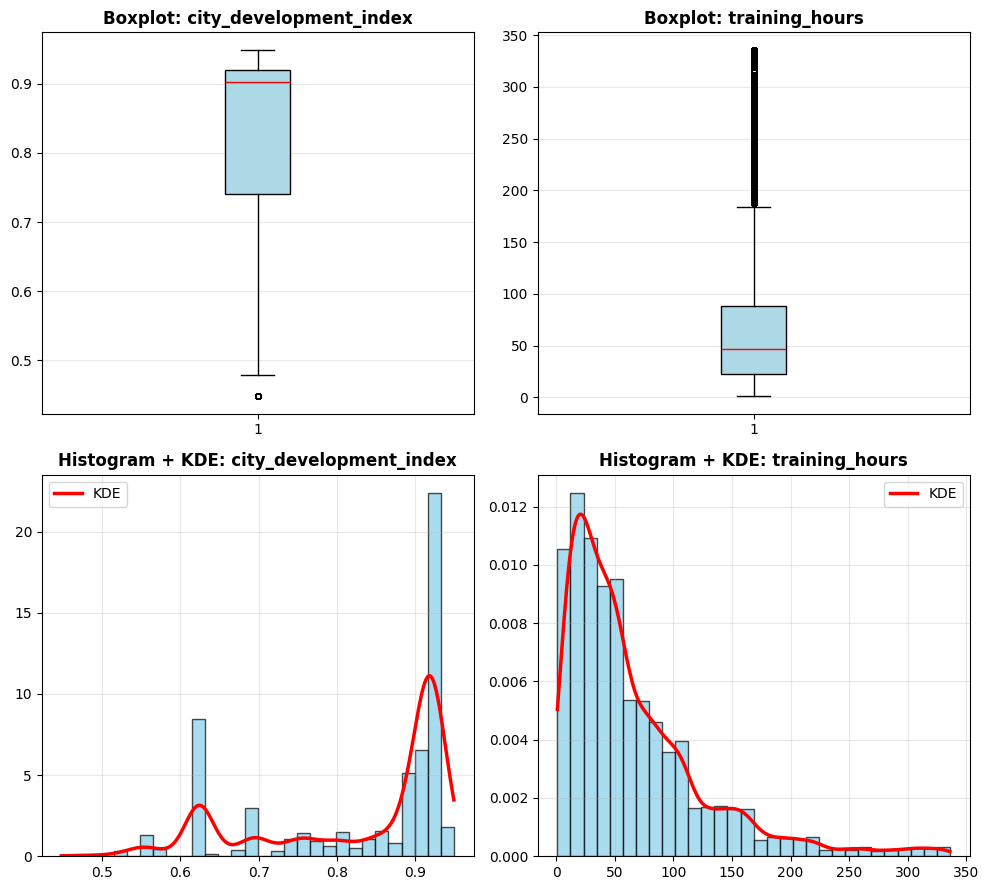

In [14]:
numeric_info = [
    (col_names.index('city_development_index'), 'city_development_index'),
    (col_names.index('training_hours'), 'training_hours'),
]

print("1. PHÂN TÍCH MISSING VALUES:")
print("-" * 55)
for idx,name in numeric_info:
    col = data[:,idx]
    missing_count = np.sum(col == '')
    missing_pct = (missing_count / len(data)) * 100
    print(f"{name:<25}| Missing: {missing_count:6d}({missing_pct:5.2f}%)|")

print("\n2. THỐNG KÊ MÔ TẢ & KIỂM TRA CHẤT LƯỢNG (Range & Central Tendency):")
print("-" * 95)
print(f"{'Column':<25}|{'Min':<10}|{'Max':<10}|{'Mean':<10}|{'Median':<10}|{'Zeros (%)':<10}|{'Negatives':>10}|")
print("-" * 95)

for idx, name in numeric_info:
    col_float = data_clean[:, idx].astype(float)
    col_valid = col_float[~np.isnan(col_float)]
    
    min_val = np.min(col_valid)
    max_val = np.max(col_valid)
    mean_val = np.mean(col_valid)
    median_val = np.median(col_valid)
    
    zeros_pct = np.mean(col_valid == 0) * 100
    negatives = np.sum(col_valid < 0)
    
    print(f"{name:<25}|{min_val:<10.2f}|{max_val:<10.2f}|{mean_val:<10.2f}|{median_val:<10.2f}|{zeros_pct:>9.1f}%|{negatives:>10}|")

def manual_skewness(x):
    mean = np.mean(x)
    std = np.std(x)
    if std == 0: return 0.0
    return np.mean((x - mean)**3) / (std**3)

def manual_kurtosis(x):
    mean = np.mean(x)
    std = np.std(x)
    if std == 0: return 0.0
    fourth = np.mean((x - mean)**4)
    return (fourth / (std**4)) - 3

print("\n3. OUTLIERS & HÌNH DẠNG PHÂN PHỐI (Chi tiết Q1, Q3, Bounds):")
print("-" * 120) 

print(f"{'Column':<25}|{'Q1':<8}|{'Q3':<8}|{'Low_Bound':<10}|{'Up_Bound':<10}|{'Outliers':<15}|{'Skewness':<10}|{'Kurtosis':<10}|{'Shape':>10}|")
print("-" * 120)

for idx, name in numeric_info:
    col_float = data_clean[:, idx].astype(float)
    col_valid = col_float[~np.isnan(col_float)]
    
    Q1 = np.percentile(col_valid, 25)
    Q3 = np.percentile(col_valid, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = np.sum((col_valid < lower) | (col_valid > upper))
    outlier_pct = outliers / len(col_valid) * 100
    
    skew = manual_skewness(col_valid)
    kurt = manual_kurtosis(col_valid)
    
    if skew > 0.5:
        shape = "Lệch phải"
    elif skew < -0.5:
        shape = "Lệch trái"
    else:
        shape = "Đối xứng"
    
    
    print(f"{name:<25}|{Q1:<8.2f}|{Q3:<8.2f}|{lower:<10.2f}|{upper:<10.2f}|{outlier_pct:<10.2f}|{skew:<10.4f}|{kurt:<10.4f}|{shape:>10}|")
def simple_kde(x, bandwidth=None):
    x = np.asarray(x)
    if len(x) == 0:
        return np.array([]), np.array([])
    if bandwidth is None:
        std = np.std(x)
        if std == 0: std = 1.0
        bandwidth = 1.06 * std * len(x) ** (-0.2)  
    
    grid = np.linspace(x.min(), x.max(), 300)
    density = np.zeros_like(grid, dtype=float)
    
    for val in x:
        density += np.exp(-0.5 * ((grid - val) / bandwidth)**2)
    
    density /= (len(x) * bandwidth * np.sqrt(2 * np.pi))
    return grid, density

print("\n4. BIỂU ĐỒ TRỰC QUAN HÓA:")
plot_numeric(numeric_info,data_clean,simple_kde)

1. Chất lượng dữ liệu: Rất tốt. Sạch 100% (không có Missing Values), các giá trị Min/Max đều hợp lý về mặt logic.
2. Biến training_hours (Giờ học): Phân phối lệch phải nặng. Đa số ứng viên học ít (< 50 giờ). Nhóm học nhiều (> 185 giờ) xuất hiện dưới dạng Outliers (chiếm 5.1%) nhưng là số liệu thật.
- Hành động: Nên chuẩn hóa để giảm độ lệch.
3. Biến city_development_index: Phân phối lệch trái. Phần lớn ứng viên đến từ các thành phố có chỉ số phát triển cao (> 0.9).


### Với mỗi cột có kiểu dữ liệu dạng phân loại (categorical), các giá trị được phân bố như thế nào? 

=== 1. KIỂM TRA TÍNH NHẤT QUÁN (CASE SENSITIVITY) ===
----------------------------------------------------------------------
=> Không phát hiện lỗi viết hoa/thường.


=== 2. THỐNG KÊ & PHÁT HIỆN NHÓM HIẾM (RARE VALUES) ===
Tên cột               |Missing(%)  |  Unique|Cảnh báo nhóm hiếm (<1%)    |
--------------------------------------------------------------------------------
city                  |0    ( 0.00)|     123|            Có 106 nhóm < 1%|
gender                |4508 (23.53)|       3|               Phân phối tốt|
relevent_experience   |0    ( 0.00)|       2|               Phân phối tốt|
enrolled_university   |386  ( 2.01)|       3|               Phân phối tốt|
education_level       |460  ( 2.40)|       5|               Phân phối tốt|
major_discipline      |2813 (14.68)|       6|               Phân phối tốt|
experience            |65   ( 0.34)|      22|                    Hiếm: 20|
company_size          |5938 (30.99)|       8|               Phân phối tốt|
company_type         

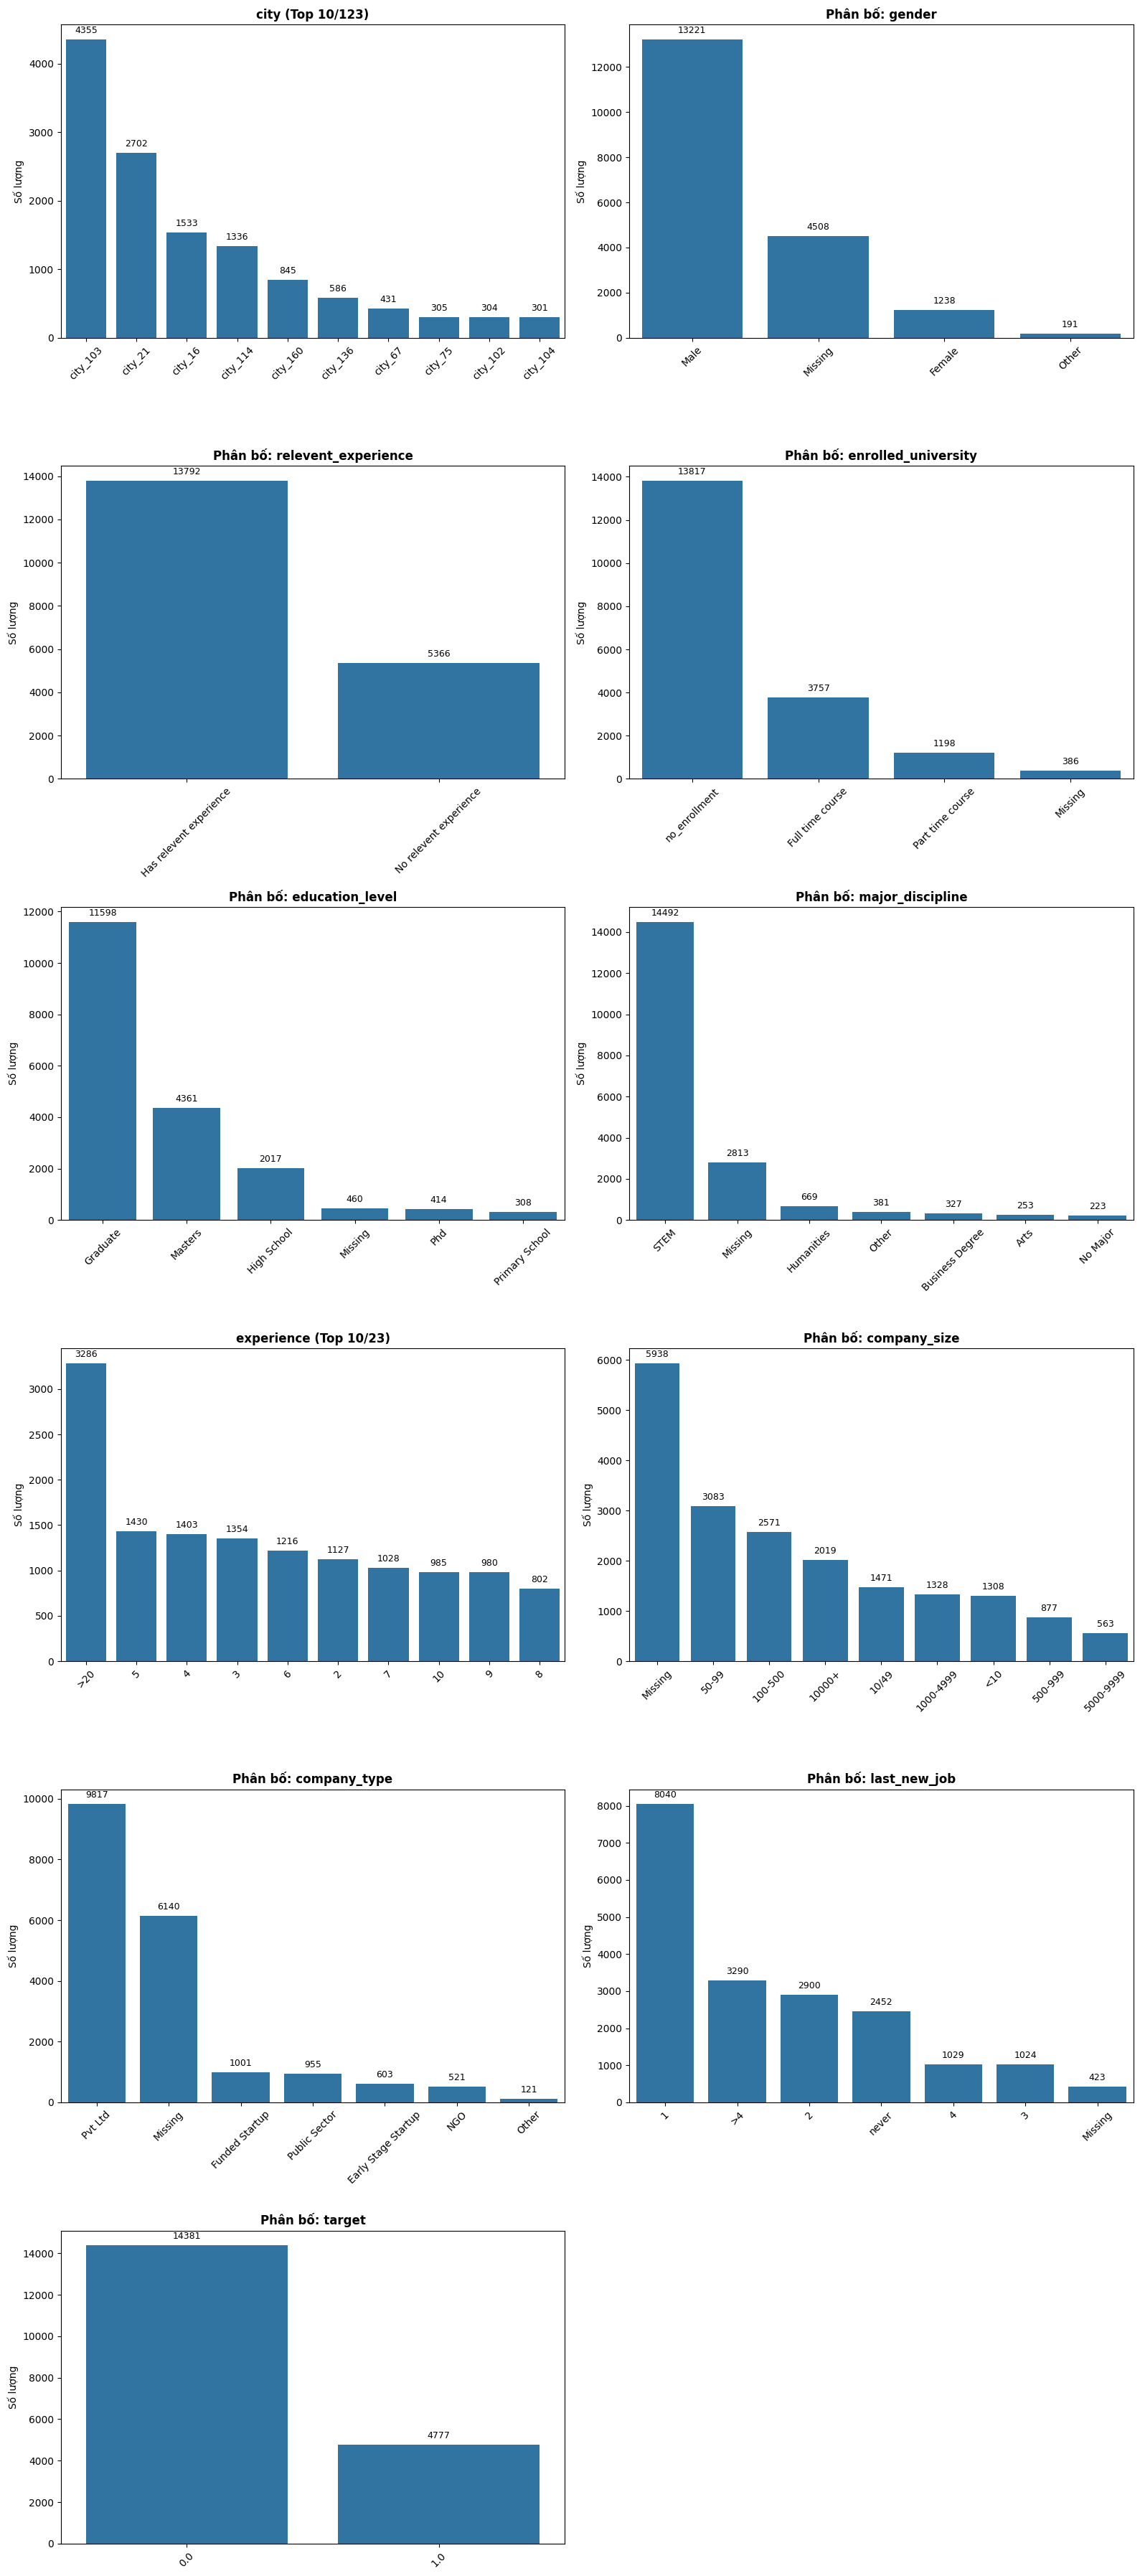

In [15]:
cat_cols = [
    (idx, name) for idx, name in enumerate(col_names) 
    if name not in ['city_development_index', 'training_hours', 'enrollee_id']
]

print("=== 1. KIỂM TRA TÍNH NHẤT QUÁN (CASE SENSITIVITY) ===")
print("-" * 70)

found_issue = False
for idx, name in cat_cols:
    col = data[:, idx]
    valid_values = col[col != '']
    
    if len(valid_values) == 0: 
        continue

    n_unique_raw = len(np.unique(valid_values))
    n_unique_lower = len(np.unique(np.char.lower(valid_values)))
    
    if n_unique_raw > n_unique_lower:
        found_issue = True
        print(f"Cột '{name}': Có thể lỗi nhập liệu (Hoa/Thường)!")
        print(f"   -> Unique gốc: {n_unique_raw}, Unique (lower): {n_unique_lower}")
        
if not found_issue:
    print("=> Không phát hiện lỗi viết hoa/thường.")


print("\n\n=== 2. THỐNG KÊ & PHÁT HIỆN NHÓM HIẾM (RARE VALUES) ===")
print(f"{'Tên cột':<22}|{'Missing(%)':<12}|{'Unique':>8}|{'Cảnh báo nhóm hiếm (<1%)':<28}|")
print("-" * 80)

for idx, name in cat_cols:
    col = data[:, idx]
    total_len = len(data)
    
    missing = np.sum(col == '')
    missing_pct = (missing / total_len) * 100.0
    
    valid_values = col[col != '']
    vals, counts = np.unique(valid_values, return_counts=True)
    

    sorted_idx = np.argsort(-counts)
    vals_sorted = vals[sorted_idx]
    counts_sorted = counts[sorted_idx]
    

    rare_categories = []
    for v, c in zip(vals_sorted, counts_sorted):
        pct = (c / len(valid_values)) * 100
        if pct < 1.0:
            rare_categories.append(f"{v}")
    
    if len(rare_categories) > 0:
        if len(rare_categories) > 3:
            warning_str = f"Có {len(rare_categories)} nhóm < 1%"
        else:
            warning_str = "Hiếm: " + ", ".join(rare_categories)
    else:
        warning_str = "Phân phối tốt"

    print(f"{name:<22}|{missing:<5}({missing_pct:>5.2f})|{len(vals):>8}|{warning_str:>28}|")


print("\n\n=== 3. BIỂU ĐỒ PHÂN BỐ (TOP 10 VALUES) ===")
plot_categorical(cat_cols,data)

1. Về Chất lượng Dữ liệu (Missing Values)
- Vấn đề: 3 cột company_type, company_size, gender thiếu dữ liệu rất nhiều (~24% - 32%).

- Hành động: Không được điền Mode (vì sẽ làm sai lệch phân phối thực tế). Nên điền giá trị mới là "Unknown" để giữ nguyên tính trung thực.

2. Về Độ đa dạng (High Cardinality)
- Vấn đề: Cột city có tới 123 mã, nhưng phần lớn là các thành phố nhỏ (<1%).

- Hành động: Chỉ giữ lại Top 10-20 thành phố phổ biến nhất. Tất cả các mã còn lại gộp chung thành nhóm "Other" để giảm chiều dữ liệu.

3. Về Sự mất cân bằng (Imbalance)
- Vấn đề:

 - major_discipline: Gần 90% là STEM. Biến này ít có giá trị phân loại (vì ai cũng giống ai).

 - gender: Chủ yếu là Male.

 - company_type: Đa số là Pvt Ltd.

 - target: Đa số là không muốn nghỉ việc.

- Hành động: Lưu ý khi mô hình hóa, các biến này có thể không đóng góp nhiều vào việc dự đoán. Cần chú ý dùng metric F1-Score thay vì Accuracy khi đánh giá mô hình.

4. Về Định dạng (Format)

- education_level & company_size & experience: Là dữ liệu có thứ bậc (Ordinal). Cần mã hóa theo thứ tự.

## Missing Data Analysis

=== BẢNG TỔNG HỢP MISSING VALUES ===
Tên cột                  |Số lượng  |Tỷ lệ (%) |
--------------------------------------------------
gender                   |4508      |23.53     |
enrolled_university      |386       |2.01      |
education_level          |460       |2.40      |
major_discipline         |2813      |14.68     |
experience               |65        |0.34      |
company_size             |5938      |30.99     |
company_type             |6140      |32.05     |
last_new_job             |423       |2.21      |


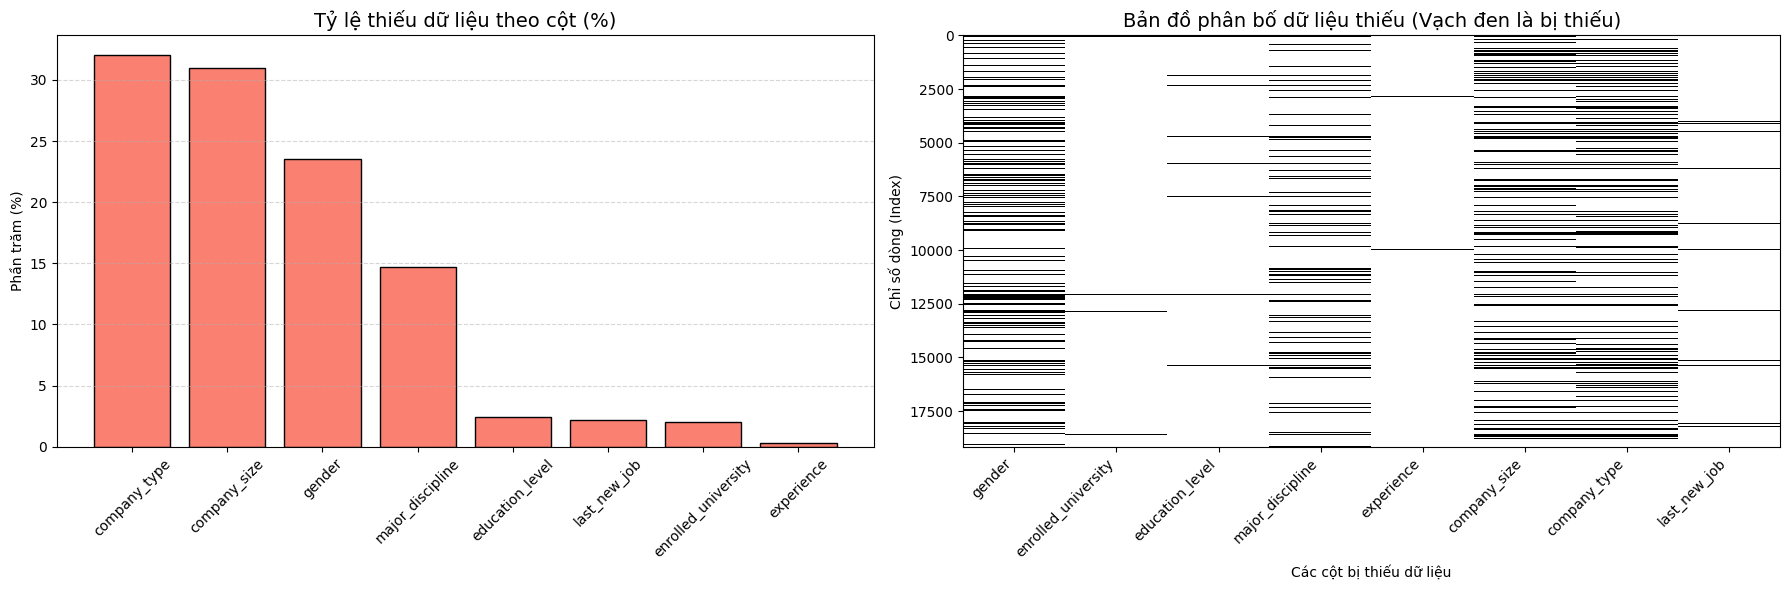

In [16]:
missing_mask = data == ''

print("=== BẢNG TỔNG HỢP MISSING VALUES ===")
print(f"{'Tên cột':<25}|{'Số lượng':<10}|{'Tỷ lệ (%)':<10}|")
print("-" * 50)

missing_stats = [] 
col_indices_missing = [] 

for idx, name in enumerate(col_names):
    count = np.sum(missing_mask[:,idx])
    pct = (count / len(data)) * 100
    if pct > 0:
        print(f"{name:<25}|{count:<10d}|{pct:<10.2f}|")
        missing_stats.append((name, pct))
        col_indices_missing.append(idx)

plot_missing_values(missing_stats,missing_mask,col_names,col_indices_missing)

- Về tổng quan, dữ liệu bị thiếu không đồng đều mà tập trung nghiêm trọng ở 3 cột là company_type (32%), company_size (31%) và gender (23.5%). Các cột còn lại thiếu không đáng kể (dưới 3%).

- Về quy luật, biểu đồ cho thấy sự trùng khớp giữa các dòng thiếu của company_size và company_type. Điều này chứng tỏ việc thiếu dữ liệu là có quy luật, khả năng cao nhóm ứng viên này đang thất nghiệp hoặc làm tự do nên bỏ trống toàn bộ thông tin công ty.

- Về giải pháp, đối với 3 cột thiếu nhiều (company và gender), tuyệt đối không được xóa dòng vì sẽ mất lượng lớn dữ liệu.Ta có thể điền giá trị mới là Unknown để mô hình học được đặc điểm của nhóm này. Đối với các cột còn lại thiếu ít, có thể điền giá trị phổ biến nhất (Mode) hoặc Median cho đơn giản.

## Phân tích tương quan giữa các feature


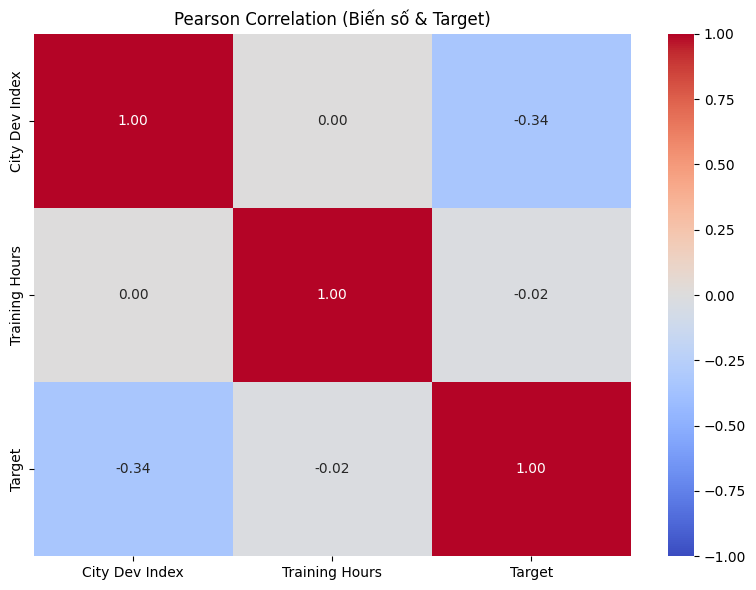

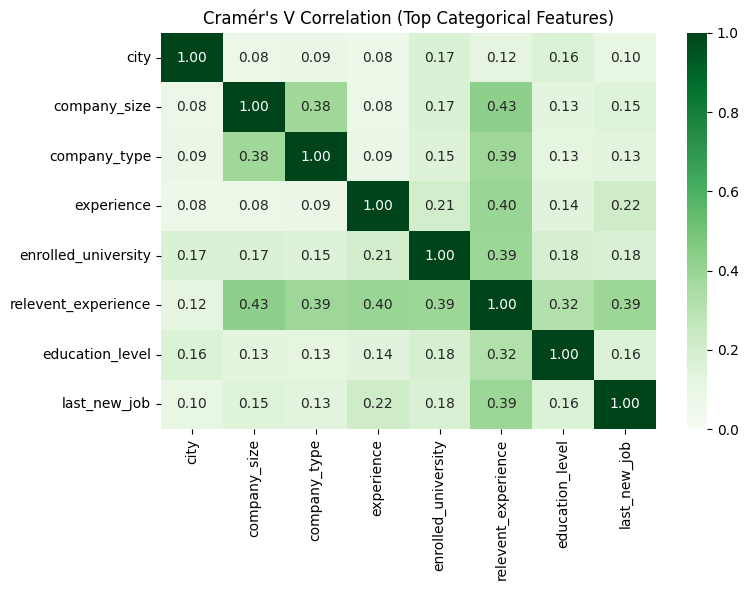


=== CRAMÉR'S V: MỨC ĐỘ ẢNH HƯỞNG ĐẾN VIỆC NGHỈ VIỆC ===
Feature                   Cramér V Score
----------------------------------------
city                      0.3875
company_size              0.2454
company_type              0.2231
experience                0.1888
enrolled_university       0.1550
relevent_experience       0.1282
education_level           0.0920
last_new_job              0.0902
gender                    0.0773
major_discipline          0.0551


In [17]:
idx_city = col_names.index('city_development_index')
idx_train = col_names.index('training_hours')
idx_target = col_names.index('target')

num_matrix = np.vstack([city_dev_index, training_hours, target])
numeric_names = ['City Dev Index', 'Training Hours', 'Target']

def pearson_corr(a, b):
    mask = ~np.isnan(a) & ~np.isnan(b)
    if mask.sum() < 2: return np.nan
    a2, b2 = a[mask], b[mask]
    a2, b2 = a2 - a2.mean(), b2 - b2.mean()
    denom = np.sqrt((a2**2).sum() * (b2**2).sum())
    return (a2*b2).sum() / denom if denom != 0 else 0.0

n_vars = len(numeric_names)
corr_num = np.zeros((n_vars, n_vars))
for i in range(n_vars):
    for j in range(n_vars):
        corr_num[i, j] = pearson_corr(num_matrix[i], num_matrix[j])

plt.figure(figsize=(8, 6))
sns.heatmap(corr_num, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, 
            xticklabels=numeric_names, yticklabels=numeric_names)
plt.title('Pearson Correlation (Biến số & Target)')
plt.tight_layout()
plt.show()


def cramers_v_np(x, y):

    x = np.array(x, dtype=object)
    y = np.array(y, dtype=object)
    
    xu, xinv = np.unique(x, return_inverse=True)
    yu, yinv = np.unique(y, return_inverse=True)
    table = np.zeros((xu.size, yu.size), dtype=np.int64)
    for xi, yi in zip(xinv, yinv): table[xi, yi] += 1
    
    n = table.sum()
    if n <= 1: return 0.0
    
    r, k = table.shape
    if r < 2 or k < 2: return 0.0
    
    row_sums = table.sum(axis=1, keepdims=True)
    col_sums = table.sum(axis=0, keepdims=True)
    expected = (row_sums @ col_sums) / n
    
    with np.errstate(divide='ignore', invalid='ignore'):
        chi2 = ((table - expected) ** 2 / expected).sum()
    
    phi2 = chi2 / n
    phi2corr = max(0.0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min(kcorr-1, rcorr-1)
    
    return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

cat_cols = [c for c in col_names if c not in 
            ['enrollee_id', 'city_development_index', 'training_hours', 'target']]


cramer_results = []
target_cat = data_clean[:, idx_target]

for c in cat_cols:
    col_idx = col_names.index(c)
    col_data = data_clean[:, col_idx]
    score = cramers_v_np(col_data, target_cat)
    cramer_results.append((c, score))

cramer_results.sort(key=lambda x: x[1], reverse=True)

top_cat_cols = [x[0] for x in cramer_results[:8]] 
m = len(top_cat_cols)
mat_cramer = np.zeros((m, m))

for i, ci in enumerate(top_cat_cols):
    for j, cj in enumerate(top_cat_cols):
        col_i = data_clean[:, col_names.index(ci)]
        col_j = data_clean[:, col_names.index(cj)]
        mat_cramer[i, j] = cramers_v_np(col_i, col_j)

plt.figure(figsize=(8, 6))
sns.heatmap(mat_cramer, xticklabels=top_cat_cols, yticklabels=top_cat_cols, 
            annot=True, fmt='.2f', cmap='Greens', vmin=0, vmax=1)
plt.title("Cramér's V Correlation (Top Categorical Features)")
plt.tight_layout()
plt.show()
print('\n=== CRAMÉR\'S V: MỨC ĐỘ ẢNH HƯỞNG ĐẾN VIỆC NGHỈ VIỆC ===')
print(f"{'Feature':<25} {'Cramér V Score':<10}")
print("-" * 40)
for name, score in cramer_results:
    print(f"{name:<25} {score:.4f}")


1. Phân tích mối quan hệ biến số (Pearson Correlation):

- Chỉ số phát triển thành phố (City Development Index): Có mối tương quan nghịch trung bình với biến mục tiêu (hệ số -0.34). Điều này chỉ ra rằng ứng viên sống tại các thành phố phát triển hơn có xu hướng ổn định công việc cao hơn, trong khi ứng viên ở các khu vực kém phát triển có tỷ lệ muốn đổi việc cao hơn.

- Số giờ đào tạo (Training Hours): Hệ số tương quan gần như bằng 0 (-0.02), cho thấy thời lượng đào tạo không có mối quan hệ tuyến tính rõ ràng với quyết định nghỉ việc.

2. Đánh giá mức độ ảnh hưởng của biến phân loại (Cramér's V):

- Các yếu tố ảnh hưởng mạnh nhất (Top Predictors): Mã thành phố (City) là yếu tố quan trọng nhất với chỉ số Cramér's V cao nhất (0.39), cho thấy yếu tố địa lý/vùng miền tác động lớn đến hành vi ứng viên. Tiếp theo là các yếu tố về môi trường doanh nghiệp như Quy mô công ty (0.25) và Loại hình công ty (0.22).

- Các yếu tố ảnh hưởng yếu (Weak Predictors): Giới tính (Gender) và Chuyên ngành học (Major Discipline) có chỉ số rất thấp (lần lượt là 0.08 và 0.05). Các biến này đóng góp rất ít thông tin vào khả năng dự báo.

3. Kiểm tra đa cộng tuyến:

- Mặc dù có mối liên hệ giữa Kinh nghiệm (Experience) và Quy mô công ty (Company Size), nhưng hệ số chưa vượt quá ngưỡng nguy hiểm (tất cả đều < 0.5). Do đó, không cần loại bỏ biến do vấn đề đa cộng tuyến.

4. Đề xuất chiến lược xử lý dữ liệu (Feature Selection):

- Giữ lại và xử lý kỹ: City (cần gom nhóm các thành phố nhỏ), Company Size/Type (cần xử lý dữ liệu thiếu bằng nhóm "Unknown"), Experience (cần chuyển sang dạng số).

- Cân nhắc loại bỏ (Drop): Gender và Major Discipline để giảm nhiễu và đơn giản hóa mô hình, do mức độ đóng góp thông tin không đáng kể.


# Initial Observations & Insights
1. Key Insights:

- Yếu tố quyết định: `City` và `Company` (Size/Type) là 2 yếu tố ảnh hưởng mạnh nhất đến việc nghỉ việc.

- Yếu tố ít quan trọng: `Gender` và `Major Discipline` gần như không có giá trị dự báo (nhiễu).

- Mất cân bằng: Dữ liệu bị lệch, chỉ có 25% ứng viên thực sự muốn đổi việc.

2. Vấn đề dữ liệu (Data Issues):

- Thiếu có hệ thống: Cột `company_type` và `company_size` thiếu ~30% dữ liệu. Đây không phải lỗi ngẫu nhiên mà khả năng cao đại diện cho nhóm "Thất nghiệp" hoặc "Freelancer".

- Dư thừa: Cột city có quá nhiều mã nhỏ lẻ (<1%) gây nhiễu.

3. Kế hoạch xử lý (Action Plan):

- Missing Values: Điền giá trị mới là "Unknown" (tuyệt đối không xóa dòng hay điền Mode cho cột công ty).

- Feature Engineering: Gom nhóm city (giữ Top 10), chuyển experience sang dạng số.

- Feature Selection: Loại bỏ gender và major_discipline.

4. Cảnh báo (Red Flags):

- Bias (Thiên kiến): Dữ liệu tập trung quá nhiều vào nhóm nam giới và ngành STEM (90%), nên mô hình có thể sẽ dự báo sai lệch khi áp dụng cho nữ giới hoặc các ngành nghề khác (Kinh tế, Xã hội).

## 1. Mối tương tác giữa Trình độ học vấn (Education Level) và Mức độ phát triển của thành phố (City Development Index) ảnh hưởng thế nào đến tỷ lệ nghỉ việc? Cụ thể: Có phải nhóm trình độ cao (Masters/Phd) sống tại các thành phố kém phát triển (< 0.65) có tỷ lệ muốn rời đi cao nhất không?

Motivation & Benefits:

- Động lực: Phân tích đơn lẻ cho thấy CDI thấp thì nghỉ việc cao. Nhưng liệu quy luật này có đúng với Cử nhân/Thạc sĩ như nhau không?

- Lợi ích: Giúp HR khoanh vùng rủi ro. Nếu rủi ro rơi vào nhóm trình độ cao ở vùng sâu vùng xa, công ty cần có gói chính sách "Retention" riêng cho nhóm này.

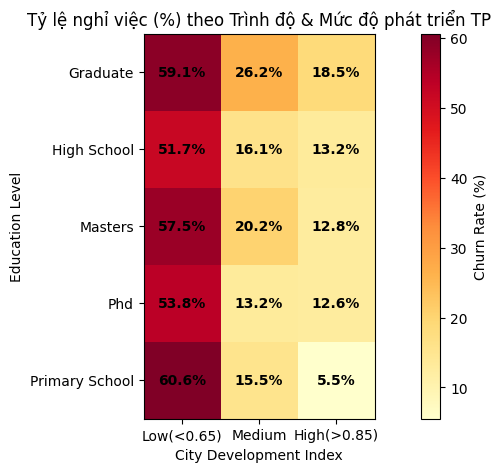

In [18]:

edu = data_clean[:,col_names.index('education_level')]
col_edu = edu[edu != 'nan']
edu_levels = np.unique(col_edu)
cdi_bins = [0,0.65,0.85,1.0]
cdi_labels = ['Low(<0.65)','Medium','High(>0.85)']


col_cdi = city_dev_index[edu != 'nan']
heatmap_matrix = np.zeros((len(edu_levels),len(cdi_labels)))
col_target = target[edu != 'nan']
for i, edu in enumerate(edu_levels):
    for j in range(len(cdi_labels)):
        lower = cdi_bins[j]
        upper = cdi_bins[j + 1]

        mask = (col_edu == edu) & (col_cdi > lower) & (col_cdi <= upper)
        if np.sum(mask) > 0:
            heatmap_matrix[i,j] = np.mean(col_target[mask]) * 100
    
plot_brain_drain(cdi_labels,heatmap_matrix,edu_levels)

1. Môi trường sống là yếu tố quyết định: Chỉ số phát triển thành phố (CDI) tác động mạnh hơn bằng cấp. Tại các thành phố kém phát triển (Low CDI), tỷ lệ nghỉ việc đồng loạt trên 50% ở mọi trình độ học vấn (màu đỏ đậm).

2. Nhân sự trình độ cao (Masters, PhD) sống ở vùng kém phát triển có xu hướng rời đi rất cao (~54-57%). Đây là rủi ro lớn cho các doanh nghiệp tỉnh lẻ.

3. Sự đối lập ở nhóm Lao động phổ thông (Primary School): Đây là nhóm nhạy cảm nhất. Họ có tỷ lệ nghỉ việc cao nhất ở vùng nghèo (60.6%) nhưng lại trung thành nhất khi được làm việc ở thành phố lớn (5.5%).

## Câu hỏi số 2 : "Startup vs. Doanh nghiệp lớn - Ai giữ chân nhân tài tốt hơn theo từng giai đoạn sự nghiệp?"

Motivation & Benefits:

- Ý nghĩa: Startups thường có tỷ lệ biến động nhân sự cao. Việc biết rõ nhóm thâm niên nào hay rời bỏ Startup nhất sẽ giúp CEO có chiến lược giữ người.

- Hành động: Định hình chiến lược tuyển dụng: Startups nên tập trung tuyển Fresher hay Senior?

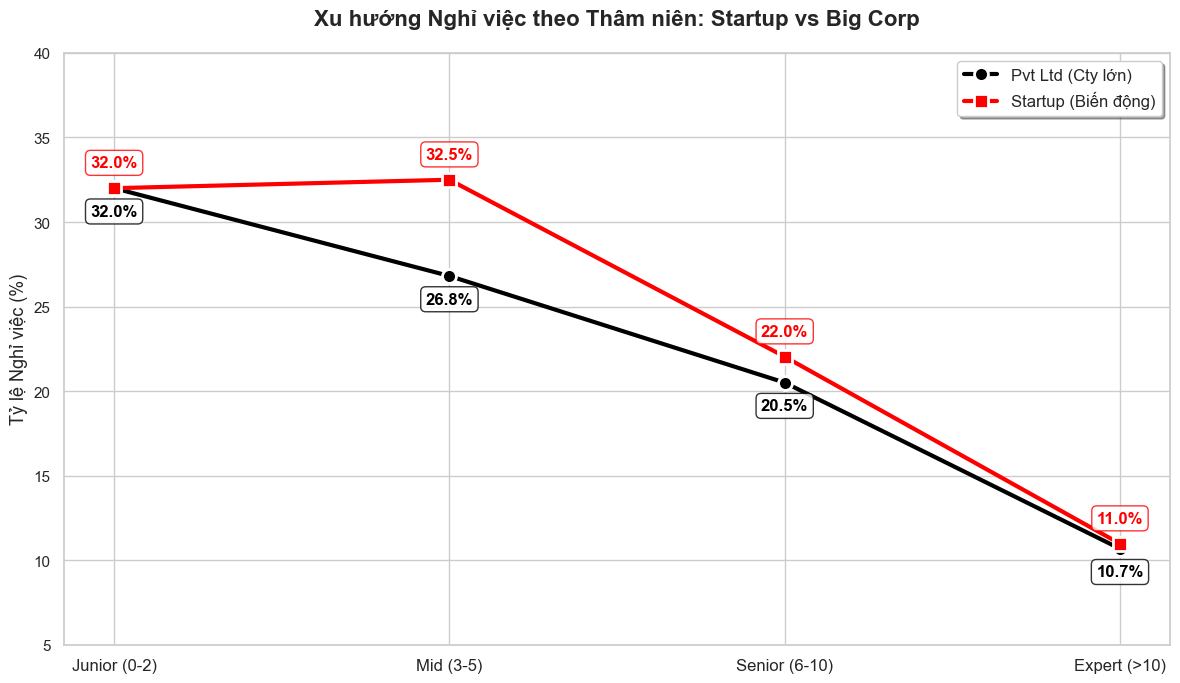

In [19]:
experience = data[:,col_names.index('experience')]
target_valid = target[experience != '']
exp_num = experience[experience != '']
exp_num[exp_num  == '>20'] = 21
exp_num[exp_num  == '<1'] = 0
exp_num = exp_num.astype(float)
bins = [0, 3, 6, 11, 50] 
labels = ['Junior (0-2)', 'Mid (3-5)', 'Senior (6-10)', 'Expert (>10)']
groups = np.digitize(exp_num,bins) - 1
types_to_compare = ['Pvt Ltd', 'Early Stage Startup']
ctype_col = data[:,col_names.index('company_type')][experience != '']

results = {}
for ctype in types_to_compare:
    rates = []
    for i in range(len(bins) - 1):
        mask = (ctype_col == ctype) & (groups == i)
        if np.sum(mask) > 0 :
            rate = np.mean(target_valid[mask]) * 100
        else:
            rate = 0
        rates.append(rate)
    results[ctype] = rates

plot_startup_vs_bigcorp(labels,results)

1. Xu hướng chung: Thâm niên càng cao, tỷ lệ nghỉ việc càng giảm ở cả hai mô hình công ty.

2. Điểm nóng (Mid-level): Sự khác biệt lớn nhất nằm ở nhóm 3-5 năm kinh nghiệm. Trong khi công ty lớn giữ chân người tốt (tỷ lệ giảm xuống 26.8%), thì Startup lại đối mặt với làn sóng nghỉ việc cao nhất tại giai đoạn này (đạt đỉnh 32.5%).

3. Sự tương đồng: Ở giai đoạn đầu sự nghiệp (Junior) và giai đoạn chuyên gia (Expert), loại hình công ty không ảnh hưởng đến quyết định đi hay ở (tỷ lệ nghỉ việc gần như y hệt nhau).

## Câu hỏi 3. Mối quan hệ giữa số giờ đào tạo (Training Hours) và tỷ lệ nghỉ việc có phải là tuyến tính không, hay tồn tại một "Ngưỡng bão hòa"? Liệu có nhóm đối tượng nào học rất nhiều nhưng lại có tỷ lệ nghỉ việc rất cao (học để đổi việc) không?
Motivation & Benefits:

- Ý nghĩa: Pearson Correlation trước đó cho thấy hệ số ~0 (không tương quan). Câu hỏi này nhằm chứng minh rằng mối quan hệ này là phi tuyến tính (Non-linear).

- Hành động: Tối ưu ngân sách L&D. Nếu phát hiện nhóm học 100-150 giờ hay nghỉ việc nhất, cần xem lại chính sách ràng buộc sau đào tạo.

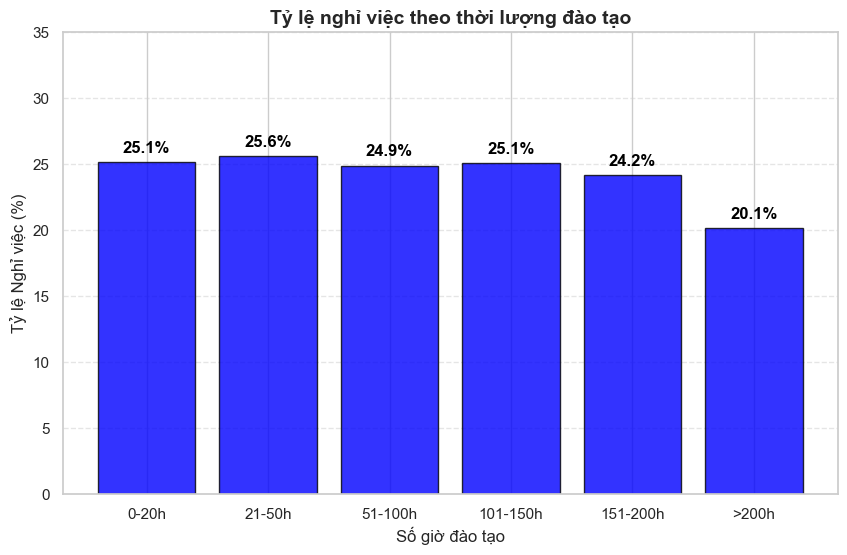

In [20]:
bins = [0, 20, 50, 100, 150, 200, 500]
labels = ['0-20h', '21-50h', '51-100h', '101-150h', '151-200h', '>200h']

col_train = training_hours
col_target = target

groups = np.digitize(col_train,bins) - 1

churn_rates = []
for i in range(len(bins) - 1):
    mask = groups == i

    if np.sum(mask) > 0 :
        rate = np.mean(col_target[mask]) * 100
    else:
        rate = 0
    churn_rates.append(rate)
plot_training_hours(labels,churn_rates)

1. Không có tác động: Với đại đa số nhân viên (học từ 0 đến 200 giờ), tỷ lệ nghỉ việc đi ngang quanh mức ~25%. Điều này chứng tỏ thời lượng đào tạo không ảnh hưởng đến quyết định đi hay ở.

2. Ngoại lệ duy nhất: Chỉ nhóm học cực nhiều (>200 giờ) mới có tỷ lệ nghỉ việc giảm rõ rệt xuống 20.1%, cho thấy sự cam kết gắn bó cao hơn.

3. Kết luận: Biến training_hours là một biến yếu (weak feature), đóng góp rất ít vào khả năng dự báo của mô hình.